In [9]:
import pandas as pd
import numpy as np
import io, zipfile
import urllib2
from cStringIO import StringIO
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from pandas.tools.plotting import scatter_matrix
import copy

%matplotlib inline


In [10]:
dfNodes = pd.read_hdf('data/LmpSolar - SFBay - Jan1-Jan7.h5','dfNodeSolarValue')
dfNodes.head(2)


,type,latitude,longitude,LMP_PRC,GHI,Solar_Value
NODE,,,,,,
AGNEW_1_N003,Load Node,37.5100,-121.84,37.929114,121.285714,33.153981
LASPULGS_6_N001,Load Node,37.4629,-122.23,38.001912,117.327381,32.171880


In [11]:
dfNodes.tail()

,type,latitude,longitude,LMP_PRC,GHI,Solar_Value
NODE,,,,,,
COLSTJT_1_B1,Generation Node,37.9900,-121.86,NaN,NaN,NaN
JVENTER_2_N001,Generation Node,37.8100,-121.77,NaN,NaN,NaN
PRKRMID_2_N001,Generation Node,37.5000,-122.18,NaN,NaN,NaN
PITSBURG_1_B1,Generation Node,38.0100,-121.91,NaN,NaN,NaN
PITSBURG_1_N001,Load Node,38.0308,-121.87,NaN,NaN,NaN


http://server.arcgisonline.com/ArcGIS/rest/services/World_Street_Map/MapServer/export?bbox=-230381.109506,-118418.181999,-62107.5536925,19463.1938167&bboxSR=3309&imageSR=3309&size=1000,819&dpi=96&format=png32&f=image


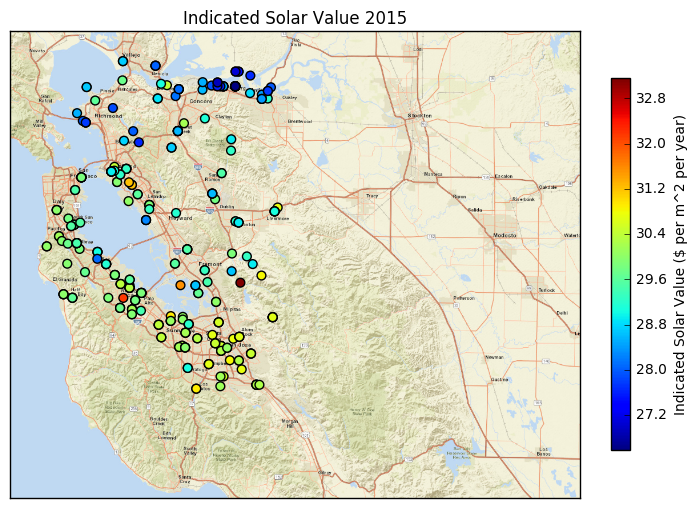

In [12]:
"""Plotting using basemap"""
# Now, using the Basemap library
plt.clf()
plt.figure(figsize=(8,8))

bbox = {'llcrnrlon':dfNodes['longitude'].min()-0.1,
        'llcrnrlat':dfNodes['latitude'].min()-0.3,
        'urcrnrlon':dfNodes['longitude'].max()+1,
        'urcrnrlat':dfNodes['latitude'].max()+0.1}

themap =  Basemap(resolution = 'c', epsg=3309,**bbox)
#themap.drawcoastlines()
#themap.drawcountries()
#themap.drawstates()
themap.arcgisimage(service='World_Street_Map', xpixels = 1000, verbose= True)
### more options at: http://server.arcgisonline.com/arcgis/rest/services

x, y = themap(dfNodes['longitude'].values, dfNodes['latitude'].values)

sc = themap.scatter(x, y,
            c=dfNodes['Solar_Value'],         # marker colour
            s=40,
            zorder=10 #to get on top
                   )
sc.set_alpha(1)
plt.colorbar(sc,label='Indicated Solar Value ($ per m^2 per year)',fraction=.03)
plt.title('Indicated Solar Value 2015')
plt.show()

In [15]:
#Fix up the data that didn't read right and while we're at it split it up
dfLmpSolar = pd.read_hdf('data/test - saveNodesLmpSolarThreaded.h5','dfLmpSolar')
dfLmpSolarA=dfLmpSolar[dfLmpSolar.index.get_level_values('Time_UTC')<'20150101T12:00']
dfLmpSolarB=dfLmpSolar[dfLmpSolar.index.get_level_values('Time_UTC')>'20150101T12:00']
print 'Original: %s A: %s B: %s' % (dfLmpSolar.shape,dfLmpSolarA.shape,dfLmpSolarB.shape)
dfNodeSolarValue = dfLmpSolar[['LMP_PRC','GHI','Solar_Value']].groupby(level=0).mean()
dfNodeSolarValueA = dfLmpSolarA[['LMP_PRC','GHI','Solar_Value']].groupby(level=0).mean()
dfNodeSolarValueB = dfLmpSolarB[['LMP_PRC','GHI','Solar_Value']].groupby(level=0).mean()




Original: (4680, 6) A: (2277, 6) B: (2304, 6)


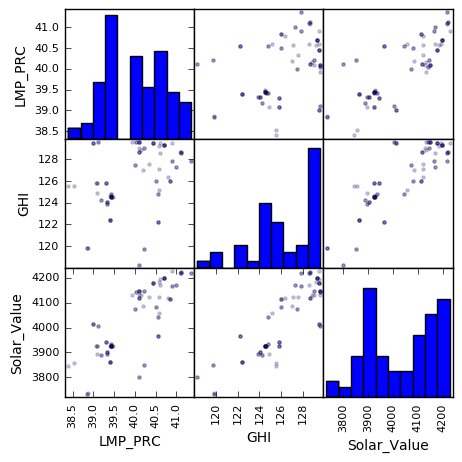

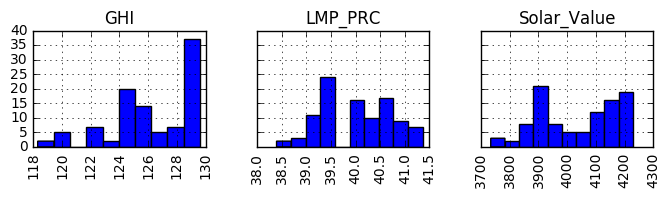

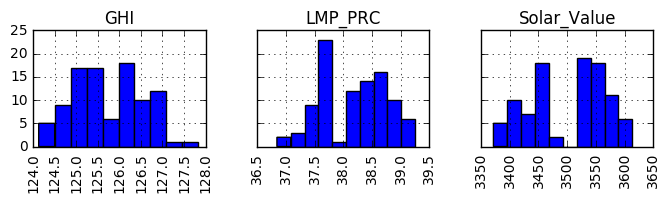

In [16]:
"""Plotting a scatter matrix on nodes"""
#Scatter matrix seems useful, pain to use

dfNodeArray = dfNodeSolarValueA[['LMP_PRC','GHI','Solar_Value']].as_matrix()
df = pd.DataFrame(dfNodeArray, columns=['LMP_PRC','GHI','Solar_Value'])
dfNodeA = dfNodeSolarValueA[['LMP_PRC','GHI','Solar_Value']].as_matrix()
dfA = pd.DataFrame(dfNodeA, columns=['LMP_PRC','GHI','Solar_Value'])
dfNodeB = dfNodeSolarValueB[['LMP_PRC','GHI','Solar_Value']].as_matrix()
dfB = pd.DataFrame(dfNodeB, columns=['LMP_PRC','GHI','Solar_Value'])

scatter_matrix(df, alpha=0.2, figsize=(5, 5),diagonal='hist')
#scatter_matrix(dfB, alpha=0.2, figsize=(5, 5),diagonal='hist')

"""Plotting histogram on nodes"""
dfA.hist(sharey=True, layout=[1,3], figsize=[8,1.5], xrot=90)
dfB.hist(sharey=True, layout=[1,3], figsize=[8,1.5], xrot=90)

plt.show()

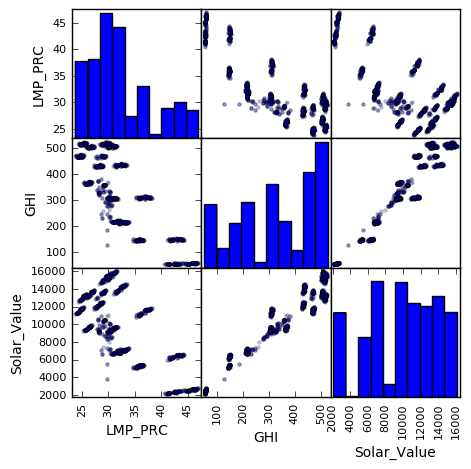

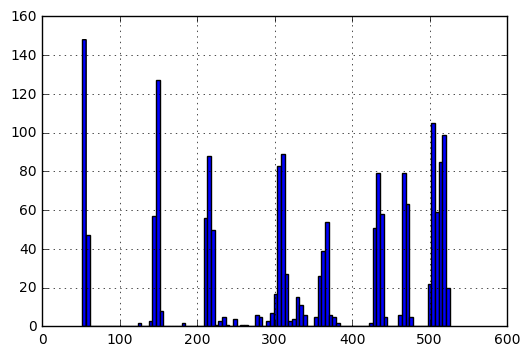

In [17]:
"""Plotting Scatter Matrix on hours"""
dfHourArray = dfLmpSolar[dfLmpSolar['GHI']>0][['LMP_PRC','GHI','Solar_Value']].as_matrix()
dfHour = pd.DataFrame(dfHourArray, columns=['LMP_PRC','GHI','Solar_Value'])
scatter_matrix(dfHour, alpha=0.2, figsize=(5, 5),diagonal='hist')
plt.show()

dfHour['GHI'].hist(bins=100)

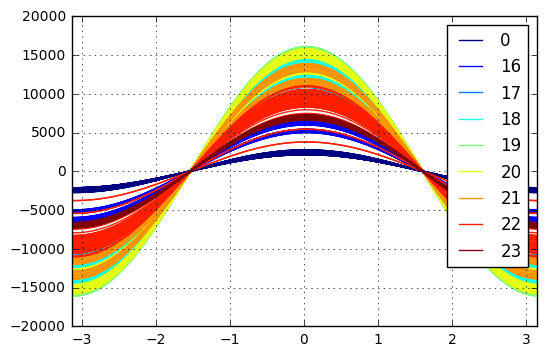

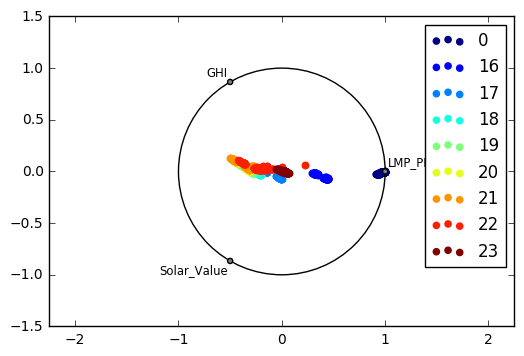

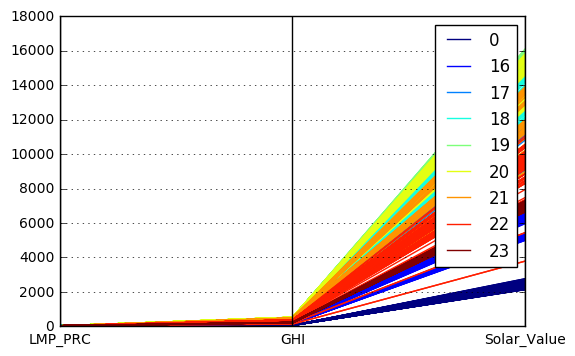

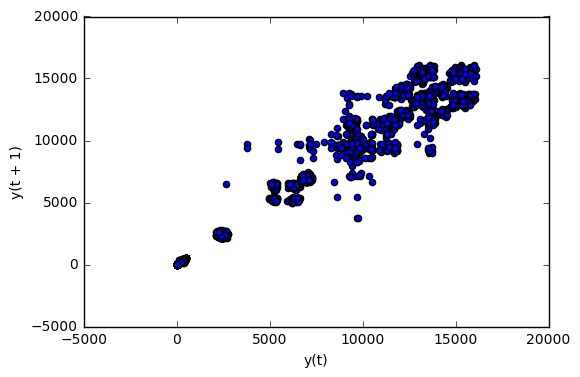

In [135]:
"""Some other crazy plotting methods"""

dfLmpSolarUnpacked = dfLmpSolar.reset_index(level=0).reset_index(level=0)
dfLmpSolarUnpacked['hour']=dfLmpSolarUnpacked['Time_UTC'].dt.hour.apply(lambda x: int(x/1))
dfLmpSolarUnpackedNumeric = dfLmpSolarUnpacked[dfLmpSolarUnpacked['GHI']>0][['LMP_PRC',
                                                                              'GHI','Solar_Value','hour']]
dfLmpSolarUnpackedNumeric.sort_values('hour', inplace=True)

pd.tools.plotting.andrews_curves(dfLmpSolarUnpackedNumeric,'hour',colormap='jet')
plt.show()

pd.tools.plotting.radviz(dfLmpSolarUnpackedNumeric,'hour',colormap='jet')
plt.show()

pd.tools.plotting.parallel_coordinates(dfLmpSolarUnpackedNumeric,'hour',colormap='jet',)
plt.show()

pd.tools.plotting.lag_plot(dfLmpSolarUnpackedNumeric)
plt.show()





In [38]:
import matplotlib as mpl
mpl.rc("savefig", dpi=200)
plt.show()

In [3]:
SolarValue = dataCAISO_LmpSolarValue(startdate='20141231T13:00-0000', enddate='20150101T15:00-0000')
SolarValue.dfLmpSolar.head(2)

NameError: name 'dataCAISO_LmpSolarValue' is not defined

In [ ]:
"""Plotting example - simple plot"""

# Get only load nodes and plot using built in pandas funciton
plt.clf()
dfNodes=SolarValue.dfNodeSolarValue[SolarValue.dfNodeSolarValue['type']=='Load Node']
dfNodes=dfNodes[dfNodes['longitude']>-180]
dfNodes=dfNodes[dfNodes['longitude']<-110]
dfNodes=dfNodes[dfNodes['latitude']>1]
dfNodes=dfNodes[dfNodes['latitude']<45]
plt.scatter(dfNodes['longitude'], dfNodes['latitude'],c=dfNodes['latitude'])
plt.axes().set_aspect('equal', 'datalim')
plt.show()

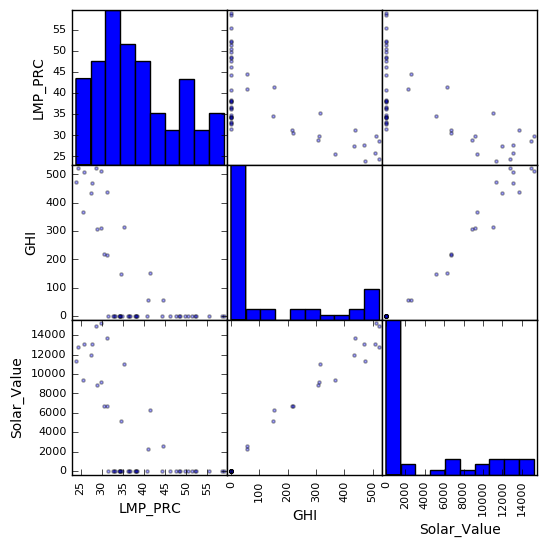

In [ ]:
"""Plotting example using basemap"""
# Now, using the Basemap library
plt.clf()
plt.figure(figsize=(8,8))

themap =  Basemap(llcrnrlon=-125,llcrnrlat=32,urcrnrlon=-113,urcrnrlat=43, resolution = 'i', epsg=3309)
#themap = Basemap(llcrnrlon = -125.0, llcrnrlat = 32.0, urcrnrlon = -113.0,urcrnrlat = 43.0,epsg=5520)
themap.drawcoastlines()
themap.drawcountries()
themap.drawstates()
themap.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 1500, verbose= True)
#themap.bluemarble()
#themap.fillcontinents(color = 'gainsboro')
#themap.drawmapboundary(fill_color='steelblue')

x, y = themap(dfNodes['longitude'].values, dfNodes['latitude'].values)

sc = themap.scatter(x, y,
            c=dfNodes['latitude'],         # marker colour
            zorder=10 #to get on top
                   )

plt.colorbar(sc,label='Latitude',fraction=.04)
plt.title('CAISO Load Nodes')
plt.show()

In [ ]:
"""Plotting example - testing for basemap arcgisimage()"""

map = Basemap(llcrnrlon=-123,llcrnrlat=37,urcrnrlon=-121,urcrnrlat=38, resolution = 'i', epsg=3309)
#http://server.arcgisonline.com/arcgis/rest/services

map.arcgisimage(service='World_Shaded_Relief', xpixels = 1500, verbose= True)
plt.show()